In [ ]:
import torch
import matplotlib.pyplot as plt
from math import log2
from utils import *

In [ ]:
x = torch.rand(50,50,3)

<matplotlib.image.AxesImage>

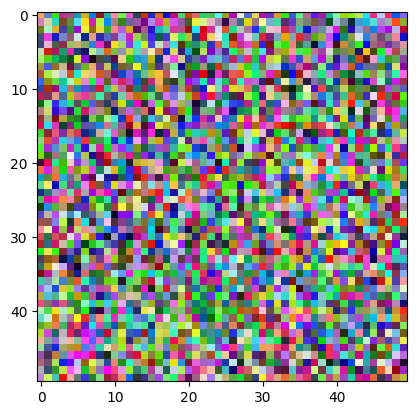

In [ ]:
plt.imshow(x)

We can discretize image by putting similar float values into the same buckets.

In [ ]:
# number of buckets
def quantize(x, n_bins):
    buckets = torch.linspace(0, 1, n_bins+1)
    return (buckets[torch.bucketize(x, buckets)-1]*256).type(torch.uint8)

In [ ]:
k = 2
x_m = quantize(x, k)

Text(0.5, 1.0, '3.0 bit image')

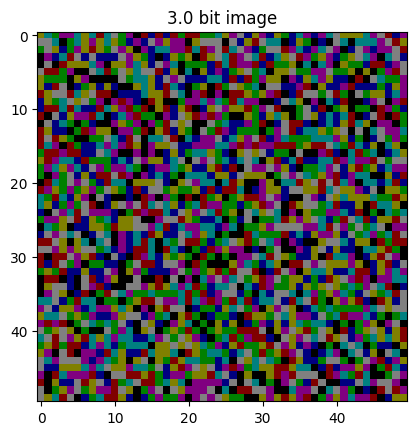

In [ ]:
plt.imshow(x_m)
plt.title(f"{3*log2(k)} bit image")

Now we'll look closer at a single channel of the image.

In [ ]:
x = x[:,:,0].clone()

<matplotlib.image.AxesImage>

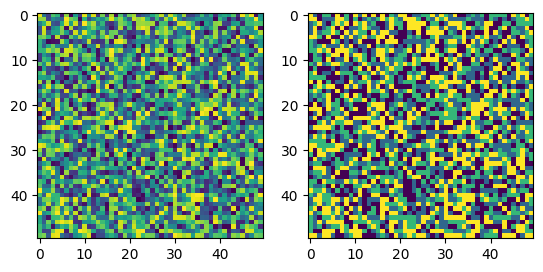

In [ ]:
axes = plt.subplots(ncols=2)[1]
axes[0].imshow(x)
axes[1].imshow(quantize(x,4))

In [ ]:
def step(x, rad=4):
    w,h = x.shape
    out = torch.zeros_like(x)
    for i in range(w):
        for j in range(h):
            block = x[max(i-rad,0):min(i+rad,w), max(j-rad,0):min(j+rad,h)]
            color = torch.argmax(torch.bincount(block.flatten()))
            out[i,j]=color
    return out

def steps(x, n=1):
    for _ in range(n):
        x = step(x)
    return x

In [ ]:
y = quantize(x, 2)

<matplotlib.image.AxesImage>

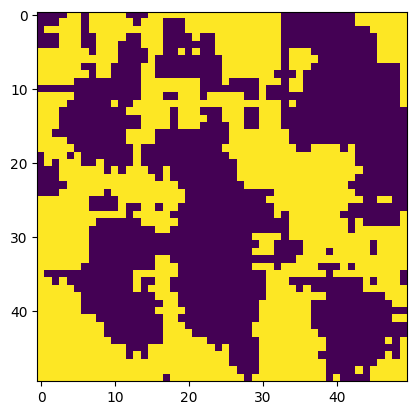

In [ ]:
plt.imshow(step(y))

In [ ]:
mod = load_cu_file('./mode_filter.cu')